In [5]:
!pip install factor_analyzer
!pip install minio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.8/93.8 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 38.7 MB/s eta 0:00:00


In [6]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from factor_analyzer import FactorAnalyzer
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity, calculate_kmo
from minio import Minio
import os

In [8]:
df = pd.read_parquet("merged_data.parquet")

features = [
    'temperature_c', 'humidity', 'rain_mm', 'wind_speed_kmh',
    'vehicle_count', 'avg_speed_kmh', 'accident_count'
]

df_fa = df[features].dropna()

print("Data Shape for Analysis:", df_fa.shape)

Data Shape for Analysis: (153, 7)


In [9]:
chi_square_value, p_value = calculate_bartlett_sphericity(df_fa)
print(f"\nBartlett’s Test p-value: {p_value}")
if p_value < 0.05:
    print("Result: Statistically significant (Data is suitable for Factor Analysis).")
else:
    print("Result: Data might not be suitable.")

kmo_all, kmo_model = calculate_kmo(df_fa)
print(f"KMO Test Value: {kmo_model:.3f}")
if kmo_model > 0.6:
    print("Result: Sampling is adequate.")
else:
    print("Result: Sampling might be inadequate.")


Bartlett’s Test p-value: 0.836681118848312
Result: Data might not be suitable.
KMO Test Value: 0.491
Result: Sampling might be inadequate.


In [10]:
fa = FactorAnalyzer(n_factors=3, rotation='varimax')
fa.fit(df_fa)

loadings = pd.DataFrame(fa.loadings_, columns=['Factor_1', 'Factor_2', 'Factor_3'], index=features)

print("\n--- Factor Loadings ---")
print(loadings)

variance = pd.DataFrame(fa.get_factor_variance(),
                        index=['SS Loadings', 'Proportion Var', 'Cumulative Var'],
                        columns=['Factor_1', 'Factor_2', 'Factor_3'])


--- Factor Loadings ---
                Factor_1  Factor_2  Factor_3
temperature_c  -0.047822 -0.060459  0.249957
humidity        0.040858 -0.055900  0.193643
rain_mm         0.026942  0.102387  0.425727
wind_speed_kmh  0.997319  0.000915  0.028571
vehicle_count   0.080392  0.263980 -0.204351
avg_speed_kmh  -0.077846  0.568570 -0.018467
accident_count  0.012781  0.214121 -0.004161


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


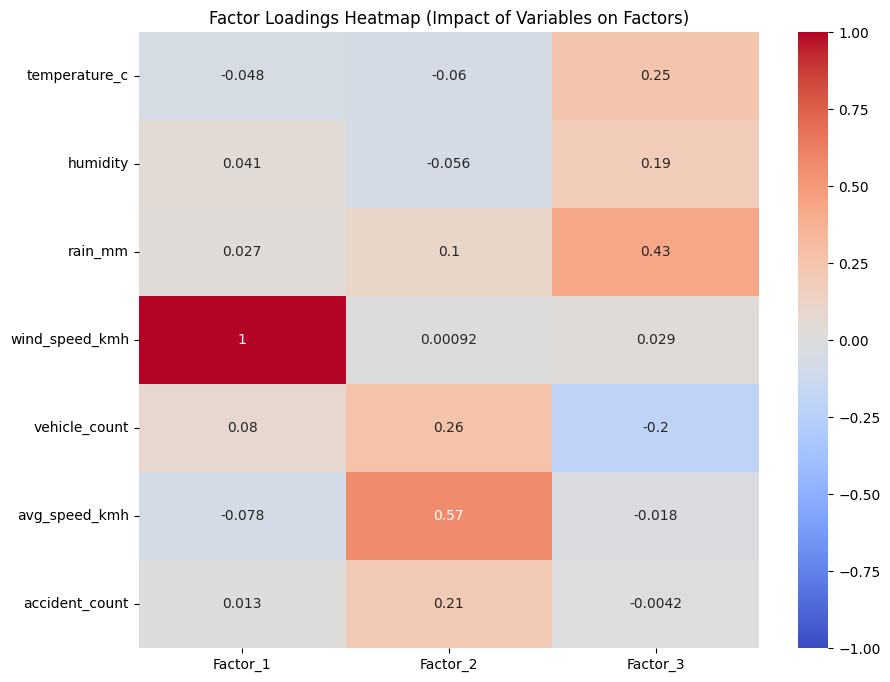

--- Factor Analysis Interpretation Report ---

**Factor_1**: Strongly influenced by ['wind_speed_kmh', 'vehicle_count', 'avg_speed_kmh']
   -> Interpretation: Likely: Weather Severity Factor

**Factor_2**: Strongly influenced by ['avg_speed_kmh', 'vehicle_count', 'accident_count']
   -> Interpretation: Likely: Traffic Flow/Stress Factor

**Factor_3**: Strongly influenced by ['rain_mm', 'temperature_c', 'vehicle_count']
   -> Interpretation: Likely: Weather Severity Factor


--- Variance Explained ---
                Factor_1  Factor_2  Factor_3
SS Loadings     1.012013  0.456069  0.324153
Proportion Var  0.144573  0.065153  0.046308
Cumulative Var  0.144573  0.209726  0.256034


In [11]:
plt.figure(figsize=(10, 8))
sns.heatmap(loadings, annot=True, cmap="coolwarm", vmin=-1, vmax=1)
plt.title("Factor Loadings Heatmap (Impact of Variables on Factors)")
plt.savefig("factor_heatmap.png")
plt.show()

report_text = "--- Factor Analysis Interpretation Report ---\n\n"
for col in loadings.columns:
    top_vars = loadings[col].abs().sort_values(ascending=False).head(3).index.tolist()
    report_text += f"**{col}**: Strongly influenced by {top_vars}\n"

    if 'rain_mm' in top_vars or 'wind_speed_kmh' in top_vars:
        label = "Likely: Weather Severity Factor"
    elif 'vehicle_count' in top_vars or 'congestion_level' in top_vars:
        label = "Likely: Traffic Flow/Stress Factor"
    elif 'accident_count' in top_vars:
        label = "Likely: Accident Risk Factor"
    else:
        label = "Unidentified Factor"

    report_text += f"   -> Interpretation: {label}\n\n"

report_text += "\n--- Variance Explained ---\n"
report_text += str(variance)

print(report_text)

In [12]:
with open("factor_analysis_report.txt", "w") as f:
    f.write(report_text)

loadings.to_csv("factor_loadings.csv")

In [ ]:
def upload_phase6_to_gold():
    client = Minio(
        "localhost:9000",
        access_key="admin",
        secret_key="password",
        secure=False
    )

    files_to_upload = [
        "factor_heatmap.png",
        "factor_analysis_report.txt",
        "factor_loadings.csv"
    ]

    print("\n--- Uploading Results to Gold Layer ---")
    bucket_name = "gold"

    if not client.bucket_exists(bucket_name):
        client.make_bucket(bucket_name)

    for file_name in files_to_upload:
        try:
            client.fput_object(bucket_name, file_name, file_name)
            print(f"Uploaded {file_name} successfully.")
        except Exception as e:
            print(f"Error uploading {file_name}: {e}")

upload_phase6_to_gold()